# Sequence Learning - Direct - English
Version 1: In this version we make the model "simple": make the encoder RNN into normal RNN first and try to see the result.  
Version 2: Learning is not very much. Following Dr Coupe's advice we try simpler model structure. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle
from paths import *
from my_utils import *
from recorder import *
from loss import *
from padding import generate_mask_from_lengths_mat, mask_it
from datetime import datetime

In [2]:
from model import PhxLearner, SimplerPhxLearner

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
# 规范用语；规定两种方式：全加载；按rec加载（舍弃了按chunk加载，处理起来更简单）
# RandomPhoneDataset; AnnoPhoneDataset; AnnoSeqDataset

In [5]:
class PhoneDataset(Dataset):
    """
    A PyTorch dataset that loads cutted wave files from disk and returns input-output pairs for
    training autoencoder. 
    
    Version 3: wav -> mel
    """
    
    def __init__(self, load_dir, load_control_path, transform=None):
        """
        Initializes the class by reading a CSV file and merging the "rec" and "idx" columns.

        The function reads the CSV file from the provided control path, extracts the "rec" and "idx" columns,
        and concatenates the values from these columns using an underscore. It then appends the ".wav" extension
        to each of the merged strings and converts the merged pandas Series to a list, which is assigned to
        the 'dataset' attribute of the class.

        Args:
        load_dir (str): The directory containing the files to load.
        load_control_path (str): The path to the CSV file containing the "rec" and "idx" columns.

        Attributes:
        dataset (list): A list of merged strings from the "rec" and "idx" columns, with the ".wav" extension.
        """
        control_file = pd.read_csv(load_control_path)
        control_file = control_file[control_file['n_frames'] > 400]
        control_file = control_file[control_file['duration'] <= 2.0]
        
        # Extract the "rec" and "idx" columns
        rec_col = control_file['rec'].astype(str)
        idx_col = control_file['idx'].astype(str).str.zfill(8)
        
        # Merge the two columns by concatenating the strings with '_' and append extension name
        merged_col = rec_col + '_' + idx_col + ".wav"
        
        self.dataset = merged_col.tolist()
        self.load_dir = load_dir
        self.transform = transform
        
    
    def __len__(self):
        """
        Returns the length of the dataset.
        
        Returns:
            int: The number of input-output pairs in the dataset.
        """
        return len(self.dataset)
    
    def __getitem__(self, idx):
        """
        Returns a tuple (input_data, output_data) for the given index.

        The function first checks if the provided index is a tensor, and if so, converts it to a list.
        It then constructs the file path for the .wav file using the dataset attribute and the provided index.
        The .wav file is loaded using torchaudio, and its data is normalized. If a transform is provided,
        the data is transformed using the specified transform. Finally, the input_data and output_data are
        set to the same data (creating a tuple), and the tuple is returned.

        Args:
        idx (int or torch.Tensor): The index of the desired data.

        Returns:
        tuple: A tuple containing input_data and output_data, both of which are the audio data
               from the .wav file at the specified index.

        Note: 
        This function assumes that the class has the following attributes:
        - self.load_dir (str): The directory containing the .wav files.
        - self.dataset (list): A list of .wav file names.
        - self.transform (callable, optional): An optional transform to apply to the audio data.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        wav_name = os.path.join(self.load_dir,
                                self.dataset[idx])
        
        data, sample_rate = torchaudio.load(wav_name, normalize=True)
        if self.transform:
            data = self.transform(data, sr=sample_rate)
        
        # # Prepare for possible in-out discrepencies in the future
        # input_data = data
        # output_data = data
        
        return data

def collate_fn(xx):
    # only working for one data at the moment
    batch_first = True
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=batch_first, padding_value=0)
    return xx_pad, x_lens


class MyTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft): 
        super().__init__()
        # self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, n_mels=64)
        # self.to_db = torchaudio.transforms.AmplitudeToDB()
        # self.transform = torchaudio.transforms.MFCC(n_mfcc=13)
    
    def forward(self, waveform, sr=16000): 
        # extract mfcc
        feature = torchaudio.compliance.kaldi.mfcc(waveform, sample_frequency=sr)

        # add deltas
        d1 = torchaudio.functional.compute_deltas(feature)
        d2 = torchaudio.functional.compute_deltas(d1)
        feature = torch.cat([feature, d1, d2], dim=-1)

        # Apply normalization (CMVN)
        eps = 1e-9
        mean = feature.mean(0, keepdim=True)
        std = feature.std(0, keepdim=True, unbiased=False)
        # print(feature.shape)
        # print(mean, std)
        feature = (feature - mean) / (std + eps)

        # mel_spec = self.transform(waveform)
        # # mel_spec = self.to_db(mel_spec)
        # mel_spec = mel_spec.squeeze()
        # mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        return feature

In [6]:
BATCH_SIZE = 128

INPUT_DIM = 39
OUTPUT_DIM = 13

INTER_DIM_0 = 16
INTER_DIM_1 = 8
INTER_DIM_2 = 3
# INTER_DIM_3 = 3

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400

LOADER_WORKER = 16
# LOADER_WORKER = 0

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = PhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
model

SimplerPhxLearner(
  (encoder): OnlyRNNEncoder(
    (rnn): LSTM(39, 3, batch_first=True)
    (lin_1): LinearPack(
      (linear): Linear(in_features=3, out_features=3, bias=True)
    )
    (act): Tanh()
    (bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): SimperRNNDecoder(
    (rnn): LSTM(13, 3, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=3, out_features=3, bias=True)
      (w_k): Linear(in_features=3, out_features=3, bias=True)
      (w_v): Linear(in_features=3, out_features=3, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=3, out_features=13, bias=True)
    )
    (act): Tanh()
  )
)

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [10]:
params

850

In [11]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
# ts = "0623152604"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)
# save_train1hist_name = "train_hist_recon{}.hst".format(ts)
# save_train2hist_name = "train_hist_reg{}.hst".format(ts)

save_valhist_name = "val_hist_{}.hst".format(ts)
# save_val1hist_name = "val_hist_recon{}.hst".format(ts)
# save_val2hist_name = "val_hist_reg{}.hst".format(ts)

In [12]:
train_losses = LossRecorder(model_save_dir + save_trainhist_name)
# train_recon_losses = LossRecorder(model_save_dir + save_train1hist_name)
# train_reg_losses = LossRecorder(model_save_dir + save_train2hist_name)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)
# valid_recon_losses = LossRecorder(model_save_dir + save_val1hist_name)
# valid_reg_losses = LossRecorder(model_save_dir + save_val2hist_name)
text_hist = HistRecorder(model_save_dir + save_txt_name)

In [13]:
READ = False
# READ = True

In [14]:
if READ: 
    valid_losses.read()
    train_losses.read()

    # model_name = last_model_namec
    model_name = "PT_0623152604_29_full.pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model = PhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
    
    model.load_state_dict(state)
    model.to(device)

In [15]:
mytrans = MyTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT)
ds = PhoneDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)

# this is to reduce the size of the dataset when the training power is not sufficient
small_len = int(0.1 * len(ds))
other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
ds, other_ds = random_split(ds, [small_len, other_len])

train_len = int(0.8 * len(ds))
valid_len = len(ds) - train_len

# Randomly split the dataset into train and validation sets
train_ds, valid_ds = random_split(ds, [train_len, valid_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=collate_fn)
valid_num = len(valid_loader.dataset)


In [16]:
len(train_loader)

178

In [17]:
EPOCHS = 30
BASE = 0

In [18]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            y = x[:, :, :13]    # extract MFCC-only data
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            train_loss += loss.item()

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            if idx % 10 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            y = x[:, :, :13]    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, attn_weight = model(x, x_lens, x_mask)

            loss = model_loss.get_loss(recon_x, y, x_mask)

            valid_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)

        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [19]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  1.073 in Step 0
Training loss  1.068 in Step 10
Training loss  1.049 in Step 20
Training loss  1.042 in Step 30
Training loss  1.036 in Step 40
Training loss  1.029 in Step 50
Training loss  1.025 in Step 60
Training loss  1.019 in Step 70
Training loss  1.013 in Step 80
Training loss  1.011 in Step 90
Training loss  1.007 in Step 100
Training loss  1.006 in Step 110
Training loss  1.004 in Step 120
Training loss  1.003 in Step 130
Training loss  1.003 in Step 140
Training loss  1.002 in Step 150
Training loss  1.004 in Step 160
Training loss  1.002 in Step 170
※※※Training loss  1.020※※※
Training timepoint saved
Valid loss  1.002 in Step 0
※※※Valid loss  1.001※※※
Epoch 1
Training loss  1.002 in Step 0
Training loss  1.001 in Step 10
Training loss  1.001 in Step 20
Training loss  1.001 in Step 30
Training loss  1.001 in Step 40
Training loss  1.001 in Step 50
Training loss  1.001 in Step 60
Training loss  1.001 in Step 70
Training loss  1.001 in Step 80
Training l

In [20]:
### Save
train_losses.save()

valid_losses.save()

text_hist.save()

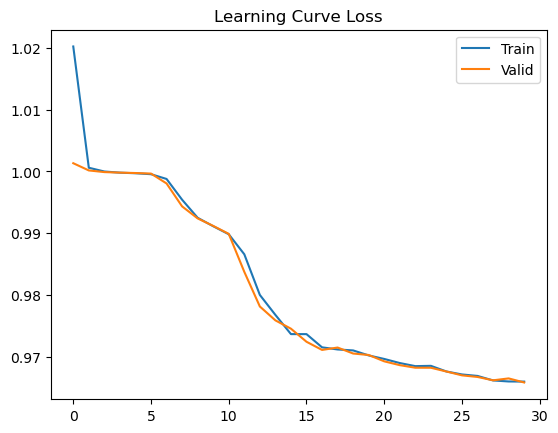

In [21]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve Loss")
plt.legend()